# Clustering: Below-Phoneme

Import libraries and helpers

In [1]:
import os, sys

from env_variables import default_font_size

directory = os.path.abspath('/Users/joris/Documents/Work/bsc ai/bt/Bachelor-Thesis/code')
sys.path.append(directory)

from dataset.loading import DataLoader
from lib.esn import ESN
from lib.clustering.clustering_metrics import *
from experiments.exp2_below_phoneme_clustering.gchc.gchc import GCHC
from experiments.exp2_below_phoneme_clustering.gchc.method import *
from experiments.helpers.experiment_helpers import *

import numpy as np
import random
import warnings
import pandas as pd

np.random.seed(0)
random.seed(0)
warnings.filterwarnings("ignore")

#### Data
Collect the training dataset.
It is restricted to 50 speakers of equal male-female distributions and only contains "SX" (phonetically diverse) sentences. The data are pre-processed into 10 steps long 14-mffc signals with 39 phoneme labels.

In [2]:
save = True

data_path = '../../../'
cache_dir = '../../cache/'
dl = DataLoader(data_path, cache_dir)

sentence = "SX"
XorZ = "X"
long_version = False
n_mels = 13
delta = False
delta_delta = False
subsamples = 10
dr = []
speakers = []

path_option = "Final"+str(long_version)+str(n_mels)+str(delta)+str(delta_delta)+str(subsamples)

if dr:
    path_option = str(dr)+path_option
if len(speakers):
    path_option = str(len(speakers))+path_option
if sentence:
    path_option = sentence+path_option

features, labels, speakers_list, dr_list, _ = dl.collectFeaturesInSegments(
    n_mels=n_mels,delta=delta,delta_delta=delta_delta,
    long_version=long_version,speakers=speakers,dr=dr,
    sentence=sentence,subsamples=subsamples,
    path_option=path_option, include_speakers_and_regions=True)


-from output
---- success


Regroup data and label arrays into a phoneme-keyed dictionary. Then, select only a subset of the phonemes and randomly sample them down to an equal number samples per phoneme.

In [3]:
from dataset.data_processing import *

def sample_speakers():
    descriptions = dl.read_descriptions("Train")
    descriptions['gender'] = descriptions.speaker_id.str[0]
    descriptions = descriptions.groupby("speaker_id").first().reset_index() # Remove duplicate speakers
    descriptions = descriptions.groupby(["dialect_region", "gender"]).sample(4, replace=False).reset_index() #get 4 Males and 4 Females from each dr
    speakers = descriptions.speaker_id.values
    return speakers

def sample_labels(k=7):
    candidate_labels = ['ch', 'jh', 'er', 'f', 'z', 'm', 'th', 'aw', 'ow', 'p', 'b', 'ay', 'dh', 'ae', 'uh', 't', 'r', 'y', 'k', 'ey', 'd', 'v', 'n', 'aa', 'w', 'ah', 'g', 'ih', 'dx', 'uw', 'eh', 'sh', 'oy', 'ng', 'iy', 's', 'hh', 'h#', 'l']
    return random.sample(candidate_labels, k)

#### Experiments pre-steps
Initialize the ESN with the parameters found in experiment 1.

In [4]:
XorZ = "X"

esn_params = {
    "in_dim": n_mels*(1+delta+delta_delta),
    "out_dim": n_mels*(1+delta+delta_delta),
    "N": 100,
    "W_in_scale": 1.1,
    "b_scale": .6,
    "spectral_radius": 2.57,
    "weights": .1
}

esn = ESN(esn_params)

#### Comparative Experiment

In [5]:
n_classes=7
samples_per_phoneme = 15

def experiment(repetitions=2, data_repetitions=2, cluster_numbers=[n_classes]):
    params = {
        #"method":[],
        "method" : [Method.SIGNALS_EUCLIDEAN, Method.STATE_EUCLIDEAN, Method.CONCEPTOR_PRED, Method.PRED_CENTROIDS],
        #"method" : [Method.CONCEPTOR_PRED_CS_ONLY, Method.CONCEPTOR_PRED, Method.CONCEPTOR_FROB],
        "init_clusters" : ["smart"]
    }
    results = []

    nmi_baseline = []
    nmi_truth = []
    acc_baseline = []
    acc_truth = []

    for i in range(data_repetitions):
        print("Data_rep ",i)
        speakers = sample_speakers()
        selected_labels = sample_labels(k=n_classes)

        phonemes, features_train, labels_train, features_test, labels_test = filter_and_downsample(features, labels, selected_labels=selected_labels, limit=samples_per_phoneme, speakers = speakers_list, selected_speakers=speakers)
        group = group_by_labels(features_train, labels_train, selected_labels=selected_labels)

        correct_assignments = [ [] for _ in range(n_classes) ]
        idx = 0
        for i, phoneme in enumerate(group.keys()):
            for _ in group[phoneme]:
                correct_assignments[i].append(idx)
                idx += 1

        print(f"{str(n_classes)} phonemes: {phonemes}")

        esn_states = [ esn.run(feature.T, XorZ=XorZ) for feature in features_train ]
        Cs = compute_Cs(signals=features_train, esn=esn, aperture="auto", normalize=True, XorZ=XorZ, cache=False, file_identifier=path_option)
        gchc_temp = GCHC(method=Method.SIGNALS_EUCLIDEAN, Cs=Cs, signals=features_train, esn_states=esn_states, XorZ=XorZ, target_sum=None)

        centroids, clusters, ds_hist, cluster_hist, centroid_hist = gchc_temp.gchc(nb_clusters=n_classes, max_epochs=100, init_clusters="random", save=False, debug=True)

        correct_clusters = gchc_temp.assignment_to_cluster_repr(correct_assignments)
        cpy = correct_clusters.copy()
        random.shuffle(cpy)
        nmi_truth.append(NMI(correct_assignments, correct_assignments))
        acc_truth.append(clas_acc(cpy, correct_clusters, phonemes, features_test, labels_test))

        clusters_random = gchc_temp.init_random(len(clusters))
        assignments_random = gchc_temp.cluster_to_assignment_repr(clusters_random)
        nmi_baseline.append(NMI(assignments_random, correct_assignments))
        acc_baseline.append(clas_acc(clusters_random, correct_clusters, phonemes, features_test, labels_test))

        for method in params["method"]:
            for init in params["init_clusters"]:
                for n_clusters in cluster_numbers:
                    NMIs = []
                    accs = []
                    accs_init = []
                    ds = []
                    print(f"Method: {method}, Cluster initialization: {init}, #clusters: {n_clusters}")
                    for _ in range(repetitions):
                        gchc_loc = GCHC(method, Cs=Cs, signals=features_train, esn_states=esn_states, XorZ=XorZ, target_sum=None)
                        centroids, clusters, ds_hist, cluster_hist,_ = gchc_loc.gchc(
                            nb_clusters=n_clusters, max_epochs=100, init_clusters=init, save=False, debug=False
                        )
                        assignment_hist = [ gchc_loc.cluster_to_assignment_repr(cluster) for cluster in cluster_hist ]

                        # Results
                        NMIs.append(NMIs_from_list(assignment_hist, correct_assignments))
                        accs.append(clas_acc(cluster_hist[-1], correct_clusters, phonemes, features_test, labels_test))
                        accs_init.append(clas_acc(cluster_hist[0], correct_clusters, phonemes, features_test, labels_test))
                        ds.append(gchc_loc.intra_dist_mean_from_list(cluster_hist))

                    results.append( {
                        "method": method,
                        "init_clusters": init,
                        "n_clusters": n_clusters,
                        "NMIs": NMIs,
                        "mean_NMI": np.mean([ n[-1] for n in NMIs ]),
                        "mean_NMI_init": np.mean([ n[0] for n in NMIs ]),
                        "accs": accs,
                        "mean_acc": np.mean(accs),
                        "mean_acc_init": np.mean(accs_init),
                        "ds": ds,
                        "mean_ds": np.mean([ d[-1] for d in ds ]),
                        "mean_ds_init": np.mean([ d[0] for d in ds ]),
                        "ds_truth": gchc_temp.intra_dist_mean(correct_clusters, method=method),
                        "ds_baseline": gchc_temp.intra_dist_mean(clusters_random, method=method)
                    } )
    return results, np.mean(nmi_baseline), np.mean(nmi_truth), np.mean(acc_baseline), np.mean(acc_truth)


results, nmi_baseline, nmi_truth, acc_baseline, acc_truth = experiment(repetitions=20, data_repetitions=20)

Data_rep  0
Filtered to 105 train and 1586 test samples.
...of shape: (10, 13)
7 phonemes: ['er', 'oy', 'sh', 'r', 'w', 'g', 'ah']
Running GCHC: 'random' initialization | Method.SIGNALS_EUCLIDEAN method | 7 clusters.
Epoch 0 # centroids: 7
Epoch 1 # centroids: 7
Epoch 2 # centroids: 7
Epoch 3 # centroids: 7
Epoch 4 # centroids: 7
Epoch 5 # centroids: 7
Converged
Method: Method.SIGNALS_EUCLIDEAN, Cluster initialization: smart, #clusters: 7
Method: Method.STATE_EUCLIDEAN, Cluster initialization: smart, #clusters: 7
Method: Method.CONCEPTOR_PRED, Cluster initialization: smart, #clusters: 7
Method: Method.PRED_CENTROIDS, Cluster initialization: smart, #clusters: 7
Data_rep  1
Filtered to 105 train and 2573 test samples.
...of shape: (10, 13)
7 phonemes: ['uh', 'eh', 't', 'w', 'l', 'ah', 'ih']
Running GCHC: 'random' initialization | Method.SIGNALS_EUCLIDEAN method | 7 clusters.
Epoch 0 # centroids: 7
Epoch 1 # centroids: 7
Epoch 2 # centroids: 7
Epoch 3 # centroids: 7
Epoch 4 # centroids: 7

     Extract the NMIs and SCs from the results for display.

In [6]:
nmis = {}
accs = {}
ds = {}
nmis_runs = {}# runs with correct number of classes
accs_runs = {}
ds_runs = {}
ds_truth = {}
ds_baseline = {}

def trial_name(result):
    return result["method"].name + " " + result["init_clusters"]

for entry in results:
    name = trial_name(entry)
    if name not in nmis.keys():
        nmis[name] = []
        accs[name] = []
        ds[name] = []
        nmis_runs[name] = []
        accs_runs[name] = []
        ds_runs[name] = []
        ds_truth[name] = []
        ds_baseline[name] = []
    nmis[name].append(entry["mean_NMI"])
    accs[name].append(entry["mean_acc"])
    ds[name].append(entry["mean_ds"])
    ds_truth[name].append(entry["ds_truth"])
    ds_baseline[name].append(entry["ds_baseline"])
    if entry["n_clusters"] == n_classes:
        nmis_runs[name] += entry["NMIs"]
        accs_runs[name] += entry["accs"]
        ds_runs[name] += entry["ds"]


Print the best results and plot the scores by cluster number

In [12]:
print("NMI scores:")
for name, nmi in nmis.items():
    print(f"{name}: {np.mean(nmi)}")
print("Random clusters:", nmi_baseline)
print("Dataset: ", nmi_truth)

print("Mean CCA:")
for name, acc in accs.items():
    print(f"{name}: {np.mean(acc)}")
print("Random clusters:", acc_baseline)
print("Dataset: ", acc_truth)
print("Mean MICD:")
for name, d in ds.items():
    print(f"{name}: {np.mean(d)}")

NMI scores:
SIGNALS_EUCLIDEAN smart: 0.4875999949424412
STATE_EUCLIDEAN smart: 0.4679623590045584
CONCEPTOR_PRED smart: 0.4875701060815289
PRED_CENTROIDS smart: 0.4645416450664598
Random clusters: 0.08712297972145726
Dataset:  1.0
Mean CCA:
SIGNALS_EUCLIDEAN smart: 0.11614453873288073
STATE_EUCLIDEAN smart: 0.126191749739389
CONCEPTOR_PRED smart: 0.12948079371632842
PRED_CENTROIDS smart: 0.12077150586566165
Random clusters: 0.12275988690084252
Dataset:  0.13023408998914415
Mean MICD:
SIGNALS_EUCLIDEAN smart: 0.22575941063463686
STATE_EUCLIDEAN smart: 1.4982324161916973
CONCEPTOR_PRED smart: 0.0032961048635753087
PRED_CENTROIDS smart: 0.7498921654304729


In [13]:
from statsmodels.stats.anova import AnovaRM
import pandas as pd

# Prepare an empty list to store the reshaped data
data = []

# Iterate over conditions and subjects to prepare the data in long format
for condition, values in nmis_runs.items():
    for subject_id, repetitions in enumerate(values):
        for repetition in repetitions:
            data.append({
                'subject': subject_id,
                'condition': condition,
                'NMI': repetition
            })

# Create a DataFrame from the reshaped data
df = pd.DataFrame(data)

print(df.head())  # Show the first few rows to verify the structure

# Run the Repeated Measures ANOVA with automatic aggregation
aovrm = AnovaRM(df, depvar='NMI', subject='subject', within=['condition'], aggregate_func='mean')
anova_results = aovrm.fit()

# Display the ANOVA results
print(anova_results)
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Aggregate the data by subject and condition (since Tukey needs one value per subject per condition)
df_agg = df.groupby(['subject', 'condition']).agg({'NMI': 'mean'}).reset_index()

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(df_agg['NMI'], df_agg['condition'], alpha=0.05)

# Display the Tukey's HSD results
print(tukey_results)


SyntaxError: invalid syntax (1757185574.py, line 3)

Plot progress over gchc iterations with k=7 clusters.

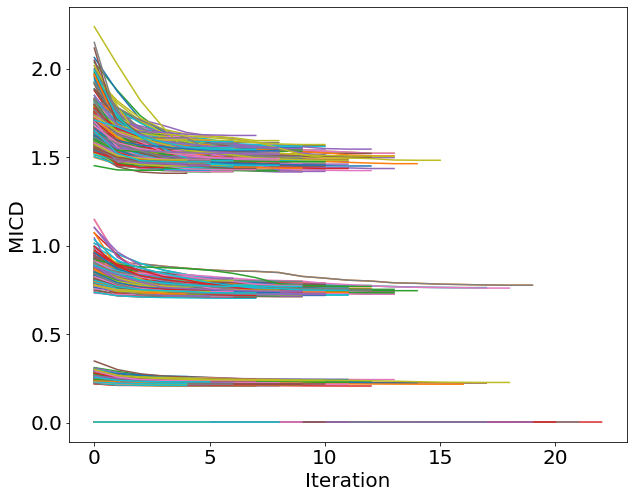

In [9]:
title="D Progress with K=7 Clusters."
plt.figure(figsize=(10,8))

#names = ["Control", "Conceptor"]
for (name, ds_run) in ds_runs.items():
    for ds_r in ds_run:
        plt.plot(ds_r)

# Legend
#plt.legend(title="D", title_fontsize=default_font_size, fontsize=default_font_size)
plt.xlabel('Iteration', fontsize=default_font_size)
plt.ylabel('MICD', fontsize=default_font_size)

# Set x-axis to display every other integer
plt.xticks(fontsize=default_font_size)

# Change tick size
plt.yticks(fontsize=default_font_size)
plt.show()

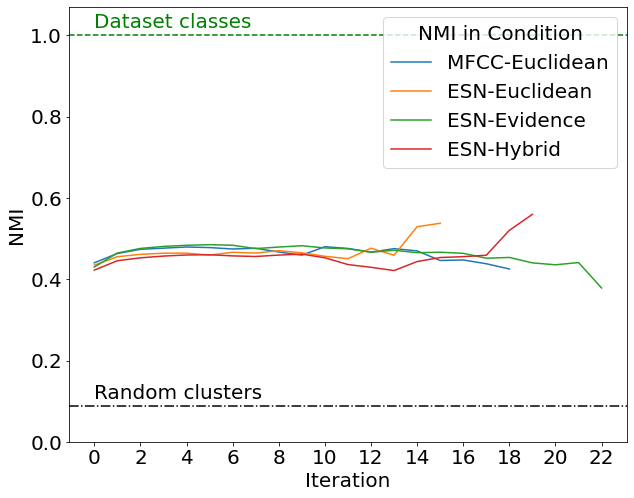

In [10]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

names = ["MFCC-Euclidean", "ESN-Euclidean", "ESN-Evidence", "ESN-Hybrid"]

max_len = max(max(len(nmis_r) for nmis_r in nmis_run) for name, nmis_run in nmis_runs.items())  # find the longest sequence
for name, nmis_run in zip(names, nmis_runs.values()):
    # Pad sequences with NaNs
    padded_nmis = [np.pad(nmis_r, (0, max_len - len(nmis_r)), constant_values=np.nan) for nmis_r in nmis_run]
    # Compute average
    avg_nmis = np.nanmean(padded_nmis, axis=0)
    plt.plot(avg_nmis, label=name)

plt.axhline(y=nmi_baseline, color='black', linestyle='dashdot')
plt.text(0, nmi_baseline + 0.01, "Random clusters", color='black', ha='left', va='bottom', fontsize=default_font_size)
plt.axhline(y=nmi_truth, color='green', linestyle='dashed')
plt.text(0, nmi_truth + 0.01, "Dataset classes", color='green', ha='left', va='bottom', fontsize=default_font_size)

plt.ylim(0, 1.07)  # Adds a margin of 5 above the highest point

# Set x-axis to display every other integer
plt.xticks(np.arange(0, max_len, 2), fontsize=default_font_size)

# Change tick size
plt.yticks(fontsize=default_font_size)

# Legend
plt.legend(title="NMI in Condition", title_fontsize=default_font_size, fontsize=default_font_size, bbox_to_anchor=(1, 1), loc='upper right')
plt.xlabel('Iteration', fontsize=default_font_size)
plt.ylabel('NMI', fontsize=default_font_size)
plt.show()

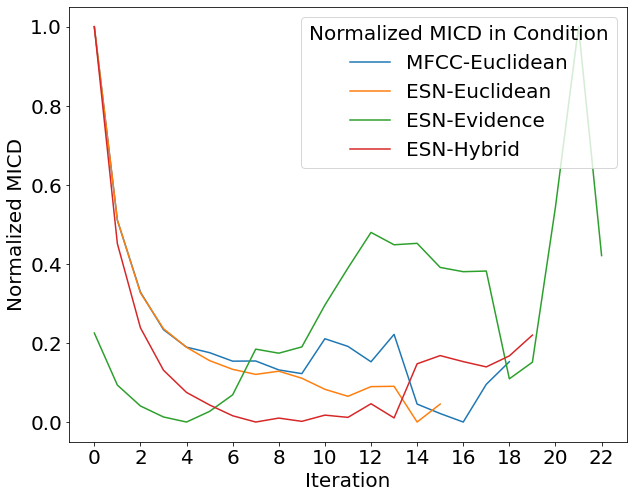

In [11]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

names = ["MFCC-Euclidean", "ESN-Euclidean", "ESN-Evidence", "ESN-Hybrid"]

max_len = max(max(len(ds_r) for ds_r in ds_run) for name, ds_run in ds_runs.items())  # find the longest sequence
for name, ds_run in zip(names, ds_runs.values()):
    padded_ds = [np.pad(ds_r, (0, max_len - len(ds_r)), constant_values=np.nan) for ds_r in ds_run]
    avg_ds = np.nanmean(padded_ds, axis=0)
    min_value = np.nanmin(avg_ds)
    max_value = np.nanmax(avg_ds)
    normalized_avg_ds = (avg_ds - min_value) / (max_value - min_value)  # Normalize to [0, 1]
    plt.plot(normalized_avg_ds, label=name)

# Legend
plt.legend(title="Normalized MICD in Condition", title_fontsize=default_font_size, fontsize=default_font_size,bbox_to_anchor=(1, 1), loc='upper right')
plt.xlabel('Iteration', fontsize=default_font_size)
plt.ylabel('Normalized MICD', fontsize=default_font_size)

# Set x-axis to display every other integer
plt.xticks(np.arange(0, max_len, 2), fontsize=default_font_size)
plt.yticks(fontsize=default_font_size)

plt.show()